# **I/ setUpEnvironment**

In [1]:
#to access files and folders
import os
#data analysis and manipulation library
import pandas as pd
#math operations for multi-dimensional arrays and matrices
import numpy as np
#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #use a specific color theme

import warnings
warnings.simplefilter("ignore")#ignore warnings during execution

#Using model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score,log_loss
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# **II/ readData**

In [2]:
#read the data
data_folder_path = '/kaggle/input/cognitiveload/UBIcomp2020/last_30s_segments/'
#read the data
print('Reading data')
label_df = pd.read_excel(data_folder_path+'labels.xlsx',index_col=0)
temp_df= pd.read_excel(data_folder_path+'temp.xlsx',index_col=0)
hr_df= pd.read_excel(data_folder_path+'hr.xlsx',index_col=0)
gsr_df = pd.read_excel(data_folder_path+'gsr.xlsx',index_col=0)
rr_df= pd.read_excel(data_folder_path+'rr.xlsx',index_col=0)
print('Done')

#check 30-second segments
print("Data shapes:")
print('Labels',label_df.shape)
print('Temperature',temp_df.shape)
print('Heartrate',hr_df.shape)
print('GSR',gsr_df.shape)
print('RR',rr_df.shape)

Reading data
Done
Data shapes:
Labels (825, 21)
Temperature (825, 30)
Heartrate (825, 30)
GSR (825, 30)
RR (825, 30)


# **III/ SMA**

In [ ]:
window = 3
#apply moving average to each 30-second segment separately
temp_df = temp_df.rolling(window,axis=1).mean()
hr_df = hr_df.rolling(window,axis=1).mean()
gsr_df = gsr_df.rolling(window,axis=1).mean()
rr_df = rr_df.rolling(window,axis=1).mean()

# **IV/ statisticalFeatures**

In [3]:
def extract_stat_features(df,data_type=''):
  stat_features_names = ['mean','std','skew','kurtosis','diff','diff2','q25','q75','qdev','max-min']
  final_names =  [data_type + '_' + x for x in stat_features_names]
  features = pd.DataFrame(columns = stat_features_names) #create empty dataframe
  values = [df.mean(axis=1).values, #mean
            df.std(axis=1).values,  #standard deviation
            df.skew(axis=1).values, #skewness
            df.kurtosis(axis=1).values, #kurtosis
            df.diff(axis=1).mean(axis=1).values, #mean value of first derivative
            df.diff(axis=1).diff(axis=1).mean(axis=1).values, #mean value of second derivative
            df.quantile(0.25,axis=1).values, #25th quantile
            df.quantile(0.75,axis=1).values,#75th quantile
            df.quantile(0.75,axis=1).values-df.quantile(0.25,axis=1).values, #quartile deviation
            df.max(axis=1).values-df.min(axis=1).values] #range
  values  = np.column_stack(values)
  return pd.DataFrame(values,columns = final_names)

In [4]:
#extract features from heart-rate data
temp_stat_features = extract_stat_features(temp_df,'temp')

hr_stat_features = extract_stat_features(hr_df,'hr')

gsr_stat_features = extract_stat_features(gsr_df,'gsr')

rr_stat_features = extract_stat_features(rr_df,'rr')

#merge all statistical features into one table
stat_feat_all = pd.concat([temp_stat_features,hr_stat_features,gsr_stat_features,rr_stat_features],axis=1)
stat_feat_all

,temp_mean,temp_std,temp_skew,temp_kurtosis,temp_diff,temp_diff2,temp_q25,temp_q75,temp_qdev,temp_max-min,...,rr_mean,rr_std,rr_skew,rr_kurtosis,rr_diff,rr_diff2,rr_q25,rr_q75,rr_qdev,rr_max-min
0,34.467000,0.014656,-0.283014,-1.993781,0.001034,0.000000,34.450001,34.480000,0.029999,0.029999,...,0.875965,0.039381,-0.111057,-0.147895,0.001716,1.185143e-03,0.854488,0.902881,0.048393,0.160389
1,34.500000,0.000000,0.000000,0.000000,0.000000,0.000000,34.500000,34.500000,0.000000,0.000000,...,0.713272,0.129408,-0.486045,-1.099709,0.000763,1.007371e-02,0.598695,0.821304,0.222609,0.403739
2,34.544001,0.011156,2.770643,6.626118,0.001379,0.000000,34.540001,34.540001,0.000000,0.040001,...,0.901683,0.078222,-0.712046,0.789044,0.009345,-9.876190e-04,0.875228,0.951275,0.076047,0.331840
3,34.620666,0.002684,4.280921,18.773201,0.000460,0.000238,34.619999,34.619999,0.000000,0.013334,...,0.883801,0.074364,-0.197954,-0.157803,-0.003433,2.172762e-03,0.835131,0.922239,0.087108,0.298656
4,35.160000,0.000000,0.000000,0.000000,0.000000,0.000000,35.160000,35.160000,0.000000,0.000000,...,0.970448,0.024030,0.156973,-1.345905,0.002479,1.030921e-16,0.951275,0.992755,0.041480,0.071899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,34.157999,0.017973,-0.917562,-1.151436,-0.001379,0.000000,34.133334,34.169998,0.036664,0.039997,...,0.830706,0.056278,-0.223922,-0.084762,0.006866,1.185143e-03,0.797799,0.868315,0.070516,0.226757
821,34.004667,0.018968,0.581940,-1.708391,-0.001379,0.000000,33.990002,34.029999,0.039997,0.039997,...,0.894217,0.076420,0.024204,-1.293893,0.003051,-4.938095e-03,0.824761,0.960953,0.136193,0.271003
822,33.786001,0.019306,0.429374,-1.878756,-0.001379,0.000000,33.770000,33.810001,0.040001,0.040001,...,0.868868,0.052516,0.600912,0.737710,0.002289,-5.925714e-04,0.836513,0.884907,0.048393,0.221227
823,34.080557,0.003043,5.477226,30.000000,-0.000575,0.000595,34.080002,34.080002,0.000000,0.016666,...,0.758900,0.138672,-1.354974,2.563826,0.002861,3.950476e-04,0.753553,0.796416,0.042863,0.641557


In [5]:
test_ids = ['3caqi','6frz4','bd47a','f1gjp','iz3x1']

train_ids = ['1mpau', '2nxs5', '5gpsc', '7swyk', '8a1ep', 'b7mrd',
       'c24ur', 'dkhty', 'e4gay', 'ef5rq', 'f3j25', 'hpbxa',
       'ibvx8', 'iz2ps', 'rc1in', 'tn4vl', 'wjxci', 'yljm5']

X_train = []
y_train = []
X_test = []
y_test = []
user_train = []
user_test = []

for user in label_df.user_id.unique():
    if user in train_ids:
        user_features = stat_feat_all[label_df.user_id == user]
        X_train.append(user_features)
        y = label_df.loc[label_df.user_id == user, 'level'].values
        
        # Convert labels (rest,0,1,2) to binary (rest vs task)
        y[y == 'rest'] = -1
        y = y.astype(int) + 1
        y[y > 0] = 1
        y_train.extend(y)
        
        temp = label_df.loc[label_df.user_id==user,'user_id'].values #labels
        user_train.extend(temp)
    elif user in test_ids:
        user_features = stat_feat_all[label_df.user_id == user]
        X_test.append(user_features)
        y = label_df.loc[label_df.user_id == user, 'level'].values
        
        # Convert labels (rest,0,1,2) to binary (rest vs task)
        y[y == 'rest'] = -1
        y = y.astype(int) + 1
        y[y > 0] = 1
        y_test.extend(y)
        
        temp = label_df.loc[label_df.user_id==user,'user_id'].values #labels
        user_test.extend(temp)

# Concatenate and convert to DataFrame/NumPy array
X_train = pd.concat(X_train, ignore_index=True)
y_train = np.array(y_train)
X_test = pd.concat(X_test, ignore_index=True)
y_test = np.array(y_test)

print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)


Train data: (632, 40) (632,)
Test data: (193, 40) (193,)


# **IV/ Preprocessing**

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# **V/ featureSelection**

None

# **VI/ Experiment**

# **Logistic Regession**

User of train_fold(0) : ['1mpau' '2nxs5' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'e4gay' 'ef5rq' 'f3j25'
 'ibvx8' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(0) :['5gpsc' 'dkhty' 'hpbxa']
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

User of train_fold(1) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'ef5rq'
 'f3j25' 'hpbxa' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci']
User of val_fold(1) :['e4gay' 'ibvx8' 'yljm5']
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

User of train_fold(2) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'e4gay'
 'ef5rq' 'hpbxa' 'ibvx8' 'rc1in' 'wjxci' 'yljm5']
User of val_fold(2) :['f3j25' 'iz2ps' 'tn4vl']
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

User of tra

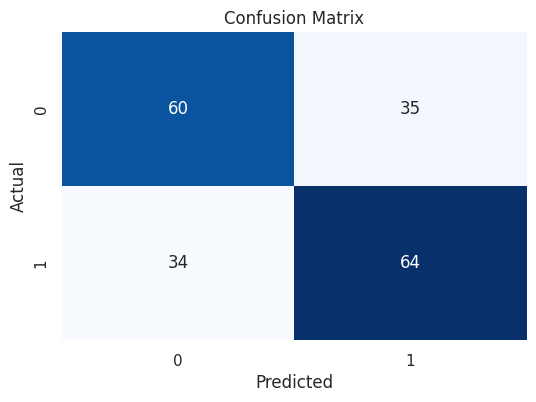

Accucracy all fold: [0.58695652 0.6875     0.52678571 0.67592593 0.70833333 0.54464286]
Mean: 0.6216907254044935 ---- Std: 0.07179723665815468
LogLoss all fold: [0.68774186 0.64130155 0.68272359 0.64909018 0.63006673 0.69047436]
Mean: 0.6635663761561795 ---- Std: 0.024162646303383842


In [7]:
# K-Fold Cross-Validation với 6 folds
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}')    

    logreg = LogisticRegression()
    # Find best parmeter 
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],        
        'solver': ['liblinear']         
    }
    grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_pred_prob = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_pred_prob)

    fold_results.append({
        "fold": fold,
        "model": logreg,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_lr = best_model.predict(X_test)
y_pred_lr_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
lr = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
class_report = classification_report(y_test, y_pred_lr)
lr_logloss = log_loss(y_test, y_pred_lr_proba)

print("Report:" + class_report)
print(f"ACCURACY: {lr}")
print(f"LOGLOSS: {lr_logloss}")


# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_lr)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy all fold: {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"LogLoss all fold: {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **LDA**

In [ ]:
# K-Fold Cross-Validation với 5 folds
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}')    

    lda = LinearDiscriminantAnalysis()
    param_grid = {
        'solver': ['svd', 'lsqr', 'eigen'],  
        'shrinkage': [None, 'auto', 0.1, 0.5, 0.9] 
    }
    grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_pred_prob = grid_search.predict_proba(X_val_fold)


    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_pred_prob)

    fold_results.append({
        "fold": fold,
        "model": lda,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)
    
    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_lda = best_model.predict(X_test)
y_pred_lda_prob = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
lda = accuracy_score(y_test, y_pred_lda)
conf_matrix = confusion_matrix(y_test, y_pred_lda)
class_report = classification_report(y_test, y_pred_lda)
logloss_lda = log_loss(y_test, y_pred_lda_prob)

print("Report:" + class_report)
print(f"ACCURACY: {lda}")
print(f"LOGLOSS: {logloss_lda}")


# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_lda)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **knn**

In [ ]:
# K-Fold Cross-Validation với 5 folds
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    knn = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],        # Số lượng láng giềng k
        'weights': ['uniform', 'distance'],     # Trọng số: uniform (các điểm đều quan trọng), distance (trọng số theo khoảng cách)
        'metric': ['euclidean', 'manhattan', 'minkowski']  # Loại khoảng cách: Euclidean, Manhattan hoặc Minkowski
    }
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_prob = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_val_pred_prob)

    fold_results.append({
        "fold": fold,
        "model": knn,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_knn = best_model.predict(X_test)
y_pred_knn_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
knn = accuracy_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
class_report = classification_report(y_test, y_pred_knn)
logloss_knn = log_loss(y_test, y_pred_knn_proba)

print("Report:" + class_report)
print(f"ACCURACY: {knn}")
print(f"LOGLOSS: {logloss_knn}")


# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_knn)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **DecisionTreeClassifier**

In [ ]:
# K-Fold Cross-Validation với 5 folds
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    cart = DecisionTreeClassifier()
    param_grid = {
        'criterion': ['gini', 'entropy'],   # Chỉ số phân chia: Gini hoặc Entropy
        'max_depth': [None, 10, 20, 30, 40, 50],  # Chiều sâu tối đa của cây
        'min_samples_split': [2, 10, 20],  # Số mẫu tối thiểu để chia nút
        'min_samples_leaf': [1, 5, 10],    # Số mẫu tối thiểu tại mỗi nút lá
        'max_features': [None, 'auto', 'sqrt', 'log2']  # Số lượng đặc trưng được xem xét tại mỗi nút phân chia
    }

    grid_search = GridSearchCV(estimator=cart, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
  
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_prob = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_val_pred_prob)

    fold_results.append({
        "fold": fold,
        "model": cart,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_cart = best_model.predict(X_test)
y_pred_cart_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
cart = accuracy_score(y_test, y_pred_cart)
conf_matrix = confusion_matrix(y_test, y_pred_cart)
class_report = classification_report(y_test, y_pred_cart)
logloss_cart = log_loss(y_test, y_pred_cart_proba)

print("Report:" + class_report)
print(f"ACCURACY: {cart}")
print(f"LOGLOSS: {logloss_cart}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_cart)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **GaussianNB**

In [ ]:
# K-Fold Cross-Validation với 5 folds
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    nb = GaussianNB()
    param_grid = {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Điều chỉnh biến nhỏ để tăng độ ổn định tính toán
    }

    grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
  
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_proba = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": nb,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_gnb = best_model.predict(X_test)
y_pred_gnb_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
gnb = accuracy_score(y_test, y_pred_gnb)
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
class_report = classification_report(y_test, y_pred_gnb)
logloss_gnb = log_loss(y_test, y_pred_gnb_proba)

print("Report:" + class_report)
print(f"ACCURACY: {gnb}")
print(f"LOGLOSS: {logloss_gnb}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_gnb)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **AdaBoots**

In [ ]:
# K-Fold Cross-Validation với 5 folds
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    adaboost = AdaBoostClassifier()
    param_grid = {
        'n_estimators': [50, 100, 200],  # Số lượng bộ phân loại cơ sở (number of weak learners)
        'learning_rate': [0.01, 0.1, 1.0],  # Tốc độ học (learning rate)
    }

    grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
   
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_proba = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": adaboost,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_ab = best_model.predict(X_test)
y_pred_ab_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
ab = accuracy_score(y_test, y_pred_ab)
conf_matrix = confusion_matrix(y_test, y_pred_ab)
class_report = classification_report(y_test, y_pred_ab)
logloss_ab = log_loss(y_test, y_pred_ab_proba)

print("Report:" + class_report)
print(f"ACCURACY: {ab}")
print(f"LOGLOSS: {logloss_ab}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_ab)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **RandomForestClassifier**

In [ ]:
# K-Fold Cross-Validation với 5 folds
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    rf = RandomForestClassifier()
    param_grid = {
        'n_estimators': [100, 200, 300],  # Number of trees in the forest
        'max_depth': [10, 20, 30],        # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
    }

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_proba = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss_fold_rf = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": rf,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss_fold_rf)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_rf = best_model.predict(X_test)
y_pred_rf_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
rf = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)
logloss_rf = log_loss(y_test, y_pred_rf_proba)

print("Report:" + class_report)
print(f"ACCURACY: {rf}")
print(f"LOGLOSS: {logloss_rf}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_rf)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# GradientBoostingClassifier

In [ ]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]

    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    gbm = GradientBoostingClassifier()
    param_grid = {
        'n_estimators': [100, 200, 300],  # Number of boosting stages to be run
        'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
        'max_depth': [3, 5, 7],          # Maximum depth of the tree
        'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4]    # Minimum number of samples required at each leaf node
    }

    grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_proba = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss_fold_gb = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": gbm,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss_fold_gb)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_gb = best_model.predict(X_test)
y_pred_gb_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
gb = accuracy_score(y_test, y_pred_gb)
conf_matrix = confusion_matrix(y_test, y_pred_gb)
class_report = classification_report(y_test, y_pred_gb)
logloss_gb = log_loss(y_test, y_pred_gb_proba)

print("Report:" + class_report)
print(f"ACCURACY: {gb}")
print(f"LOGLOSS: {logloss_gb}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_gb)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(accuracy_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# SVM

In [ ]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    svm = SVC(probability=True)
    param_grid = {
        'C': [0.1, 1, 10, 100],                # Điều chỉnh độ phạt sai số
        'kernel': ['linear', 'rbf', 'poly'],    # Các loại kernel
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Tham số gamma cho RBF, poly kernels
        'degree': [2, 3, 4]                    # Bậc của polynomial kernel (nếu dùng 'poly')
    }

    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
  
    y_val_pred = grid_search.predict(X_val_fold)   
    y_val_pred_proba = grid_search.predict(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss_fold_svm = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": gbm,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss_fold_svm)
    
    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_svm = best_model.predict(X_test)
y_pred_svm_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
svm = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
class_report = classification_report(y_test, y_pred_svm)
logloss_svm = log_loss(y_test, y_pred_svm_proba)

print("Report:" + class_report)
print(f"ACCURACY: {svm}")
print(f"LOGLOSS: {logloss_svm}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_svm)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(accuracy_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

In [ ]:
data = {
    'Model': ['LR', 'LDA', 'KNN', 'CART', 'GNB', 'RF', 'AB','GB','SVM'],
    'Accuracy': [lr, lda, knn, cart, gnb, rf, ab, gb, svm]
}

# Tạo DataFrame từ dữ liệu
df = pd.DataFrame(data)

# Chuyển đổi cột 'Accuracy' thành kiểu số thực
df['Accuracy'] = df['Accuracy'].astype(float)

# Vẽ biểu đồ barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy (Test)')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1

# Thêm thông số trên các cột
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=12)

plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y = [y_pred_lr, y_pred_lda, y_pred_knn, y_pred_cart, y_pred_gnb, y_pred_rf, y_pred_ab, y_pred_gb, y_pred_svm]
Model= ['LR', 'LDA', 'KNN', 'CART', 'GNB', 'RF', 'AB','GB','SVM']
i = 0
# Tính toán đường cong ROC và AUC
for y_pred in y:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve {Model[i]}')
    i = i + 1
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
data = {
    'Model': ['LR', 'LDA', 'KNN', 'CART', 'GNB', 'RF', 'AB','GB','SVM'],
    'Logloss': [lr_logloss, logloss_lda, logloss_knn, logloss_cart, logloss_gnb, logloss_rf, logloss_ab, logloss_gb, logloss_svm]
}

# Tạo DataFrame từ dữ liệu
df = pd.DataFrame(data)

# Chuyển đổi cột 'Accuracy' thành kiểu số thực
df['Logloss'] = df['Logloss'].astype(float)

# Vẽ biểu đồ barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='Logloss', data=df, palette='viridis')
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy (Test)')

# Thêm thông số trên các cột
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=12)

plt.show()
